In [1]:
import pandas as pd
import sys
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
import datetime as dt
import joblib
import numpy as np
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Add parent folder to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.data_handler import get_games, compute_head_to_head_avg, get_season_start

/Users/simonsalaj/Documents/test_ai/StatistIQApp/Scripts/ai/data/basketball_reference


In [2]:
df = get_games()

df['home_avg_points'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_avg_points'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df[['home_head_to_head_avg_points', 'away_head_to_head_avg_points']] = df.apply(
    lambda row: compute_head_to_head_avg(row, df), axis=1
)

df['home_last_5_win_percentage'] = (
    df.groupby('home_teamId')['home_win']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_last_5_win_percentage'] = (
    df.groupby('away_teamId')['away_win']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['gameDate'] = pd.to_datetime(df['gameDate'], errors='coerce', utc=True)

df['season'] = df['gameDate'].apply(get_season_start)

df = df.sort_values('gameDate').reset_index(drop=True)

df['home_season_win_percentage'] = (
    df.groupby(['home_teamId', 'season'])['home_win']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['away_season_win_percentage'] = (
    df.groupby(['away_teamId', 'season'])['away_win']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['home_advantage'] = 1

# Offensive Efficiency (points per possession)
df['home_possessions'] = df['home_fieldGoalsAttempted'] + 0.44 * df['home_freeThrowsAttempted'] + df['home_turnovers']
df['away_possessions'] = df['away_fieldGoalsAttempted'] + 0.44 * df['away_freeThrowsAttempted'] + df['away_turnovers']

df['home_off_efficiency'] = df['home_teamScore'] / df['home_possessions'].replace(0, np.nan)
df['away_off_efficiency'] = df['away_teamScore'] / df['away_possessions'].replace(0, np.nan)

df['home_off_eff_L5'] = (
    df.groupby('home_teamId')['home_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_off_eff_L5'] = (
    df.groupby('away_teamId')['away_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_off_eff_L10'] = (
    df.groupby('home_teamId')['home_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)
df['away_off_eff_L10'] = (
    df.groupby('away_teamId')['away_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)

# Defensive Efficiency (points allowed)
df['home_def_efficiency'] = (
    df.groupby('home_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_def_efficiency'] = (
    df.groupby('away_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

# Pace (possessions per game)
df['game_pace'] = (df['home_possessions'] + df['away_possessions']) / 2
df['home_pace_L5'] = (
    df.groupby('home_teamId')['game_pace']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_pace_L5'] = (
    df.groupby('away_teamId')['game_pace']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_pace'] = (
    df['home_fieldGoalsAttempted'] + df['home_turnovers'] + 0.44 * df['home_freeThrowsAttempted']
)
df['away_pace'] = (
    df['away_fieldGoalsAttempted'] + df['away_turnovers'] + 0.44 * df['away_freeThrowsAttempted']
)

df['home_pace_avg'] = (
    df.groupby('home_teamId')['home_pace']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_pace_avg'] = (
    df.groupby('away_teamId')['away_pace']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['pace_sum'] = df['home_pace_avg'] + df['away_pace_avg']

df['home_eFG'] = (df['home_fieldGoalsMade'] + 0.5 * df['home_threePointersMade']) / df['home_fieldGoalsAttempted'].replace(0, np.nan)
df['away_eFG'] = (df['away_fieldGoalsMade'] + 0.5 * df['away_threePointersMade']) / df['away_fieldGoalsAttempted'].replace(0, np.nan)

df['home_eFG_L5'] = (
    df.groupby('home_teamId')['home_eFG']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_eFG_L5'] = (
    df.groupby('away_teamId')['away_eFG']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_eFG_L10'] = (
    df.groupby('home_teamId')['home_eFG']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)
df['away_eFG_L10'] = (
    df.groupby('away_teamId')['away_eFG']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)

# Three-Point Shooting
df['home_3p_made_L5'] = (
    df.groupby('home_teamId')['home_threePointersMade']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_3p_made_L5'] = (
    df.groupby('away_teamId')['away_threePointersMade']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_reb_L5'] = (
    df.groupby('home_teamId')['home_reboundsTotal']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_reb_L5'] = (
    df.groupby('away_teamId')['away_reboundsTotal']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_oreb_rate'] = df['home_reboundsOffensive'] / (df['home_reboundsOffensive'] + df['away_reboundsDefensive']).replace(0, np.nan)
df['away_oreb_rate'] = df['away_reboundsOffensive'] / (df['away_reboundsOffensive'] + df['home_reboundsDefensive']).replace(0, np.nan)

df['home_oreb_rate_L5'] = (
    df.groupby('home_teamId')['home_oreb_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_oreb_rate_L5'] = (
    df.groupby('away_teamId')['away_oreb_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_to_L5'] = (
    df.groupby('home_teamId')['home_turnovers']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_to_L5'] = (
    df.groupby('away_teamId')['away_turnovers']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_ast_L5'] = (
    df.groupby('home_teamId')['home_assists']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_ast_L5'] = (
    df.groupby('away_teamId')['away_assists']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

# Points in Paint
df['home_paint_L5'] = (
    df.groupby('home_teamId')['home_pointsInThePaint']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_paint_L5'] = (
    df.groupby('away_teamId')['away_pointsInThePaint']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_fastbreak_L5'] = (
    df.groupby('home_teamId')['home_pointsFastBreak']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_fastbreak_L5'] = (
    df.groupby('away_teamId')['away_pointsFastBreak']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_pts_L3'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
)
df['away_pts_L3'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
)

df['home_pts_L5'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_pts_L5'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_pts_L10'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)
df['away_pts_L10'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)

df['home_pts_std_L10'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=3).std())
)
df['away_pts_std_L10'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=3).std())
)

df['home_home_pts_avg'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_away_pts_avg'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['home_trend_10'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(10, 2).apply(lambda x: x.iloc[-1] - x.iloc[0]))
)

df['away_trend_10'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(10, 2).apply(lambda x: x.iloc[-1] - x.iloc[0]))
)

df['home_allowed_avg'] = (
    df.groupby('home_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_allowed_avg'] = (
    df.groupby('away_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['home_win_pct_L10'] = (
    df.groupby('home_teamId')['home_win']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)
df['away_win_pct_L10'] = (
    df.groupby('away_teamId')['away_win']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)

df['expected_total_score'] = df['home_pts_L10'] + df['away_pts_L10']
df['expected_home_vs_away_def'] = df['home_off_eff_L10'] * df['away_def_efficiency']
df['expected_away_vs_home_def'] = df['away_off_eff_L10'] * df['home_def_efficiency']

df['home_off_season'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_off_season'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['home_def_season'] = (
    df.groupby('home_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_def_season'] = (
    df.groupby('away_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['expected_total_pre'] = (
    0.5 * (df['home_off_season'] + df['away_off_season']) -
    0.3 * (df['home_def_season'] + df['away_def_season']) +
    0.1 * df['pace_sum']
)

df['pace_differential'] = df['home_pace_L5'] - df['away_pace_L5']

df['off_eff_differential'] = df['home_off_eff_L10'] - df['away_off_eff_L10']
df['def_eff_differential'] = df['home_def_efficiency'] - df['away_def_efficiency']

df['eFG_differential'] = df['home_eFG_L10'] - df['away_eFG_L10']

df['home_momentum'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=2).apply(
        lambda vals: vals.iloc[-1] - vals.iloc[0] if len(vals) >= 2 else 0
    ))
)
df['away_momentum'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=2).apply(
        lambda vals: vals.iloc[-1] - vals.iloc[0] if len(vals) >= 2 else 0
    ))
)

df['home_pts_weighted'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).apply(
        lambda vals: np.average(vals, weights=range(1, len(vals)+1)) if len(vals) > 0 else np.nan
    ))
)
df['away_pts_weighted'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).apply(
        lambda vals: np.average(vals, weights=range(1, len(vals)+1)) if len(vals) > 0 else np.nan
    ))
)

df['home_TS'] = df['home_teamScore'] / (2 * (df['home_fieldGoalsAttempted'] + 0.44 * df['home_freeThrowsAttempted'])).replace(0, np.nan)
df['away_TS'] = df['away_teamScore'] / (2 * (df['away_fieldGoalsAttempted'] + 0.44 * df['away_freeThrowsAttempted'])).replace(0, np.nan)

df['home_TS_L5'] = (
    df.groupby('home_teamId')['home_TS']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_TS_L5'] = (
    df.groupby('away_teamId')['away_TS']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_tov_rate'] = df['home_turnovers'] / df['home_possessions'].replace(0, np.nan)
df['away_tov_rate'] = df['away_turnovers'] / df['away_possessions'].replace(0, np.nan)

df['home_tov_rate_L5'] = (
    df.groupby('home_teamId')['home_tov_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_tov_rate_L5'] = (
    df.groupby('away_teamId')['away_tov_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_ft_rate'] = df['home_freeThrowsAttempted'] / df['home_fieldGoalsAttempted'].replace(0, np.nan)
df['away_ft_rate'] = df['away_freeThrowsAttempted'] / df['away_fieldGoalsAttempted'].replace(0, np.nan)

df['home_ft_rate_L5'] = (
    df.groupby('home_teamId')['home_ft_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_ft_rate_L5'] = (
    df.groupby('away_teamId')['away_ft_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_rest_days'] = df.groupby('home_teamId')['gameDate'].diff().dt.days
df['away_rest_days'] = df.groupby('away_teamId')['gameDate'].diff().dt.days
df['home_rest_days'] = df['home_rest_days'].fillna(3).clip(0, 7)  # Cap at 7 days
df['away_rest_days'] = df['away_rest_days'].fillna(3).clip(0, 7)

df['rest_diff'] = df['home_rest_days'] - df['away_rest_days']

df['home_back_to_back'] = (df['home_rest_days'] <= 1).astype(int)
df['away_back_to_back'] = (df['away_rest_days'] <= 1).astype(int)

df['home_off_eff_weighted'] = (
    df.groupby('home_teamId')['home_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).apply(
        lambda vals: np.average(vals, weights=range(1, len(vals)+1)) if len(vals) > 0 else np.nan
    ))
)
df['away_off_eff_weighted'] = (
    df.groupby('away_teamId')['away_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).apply(
        lambda vals: np.average(vals, weights=range(1, len(vals)+1)) if len(vals) > 0 else np.nan
    ))
)

df = df.sort_values("gameDate").reset_index(drop=True)
base_elo = 1500
k = 20

elo = {}

df['home_elo'] = 0.0
df['away_elo'] = 0.0

for i, row in df.iterrows():
    h, a = row['home_teamId'], row['away_teamId']

    # Initialize if unseen
    elo.setdefault(h, base_elo)
    elo.setdefault(a, base_elo)

    # Assign ELO before game
    df.at[i, 'home_elo'] = elo[h]
    df.at[i, 'away_elo'] = elo[a]

    # Calculate expected probabilities
    expected_home = 1 / (1 + 10 ** ((elo[a] - elo[h]) / 400))

    # Actual result
    actual_home = 1 if row['home_win'] == 1 else 0

    # Update ELO
    elo[h] += k * (actual_home - expected_home)
    elo[a] -= k * (actual_home - expected_home)

df['elo_diff'] = df['home_elo'] - df['away_elo']


In [14]:
# Feature sets

base_features = [
    'home_avg_points',
    'away_avg_points',
    'home_head_to_head_avg_points',
    'away_head_to_head_avg_points',
    'home_last_5_win_percentage',
    'away_last_5_win_percentage',
    'home_season_win_percentage',
    'away_season_win_percentage',
]

minimal_features = [
    'elo_diff',
    'home_last_5_win_percentage',
    'away_last_5_win_percentage',
]

core_features = [
    'elo_diff',
    'home_off_eff_L10',
    'away_off_eff_L10',
    'home_def_efficiency',
    'home_last_5_win_percentage',
]

optimal_features = [
    'elo_diff',
    'home_off_eff_L10',
    'away_off_eff_L10', 
    'home_def_efficiency',
    'home_TS_L5',
    'home_last_5_win_percentage',
    'away_TS_L5',
    'home_tov_rate_L5',
    'home_eFG_L10',
    'home_avg_points',
    'away_eFG_L10',
    'away_tov_rate_L5',
    'home_head_to_head_avg_points'
]

extended_features = [
    'elo_diff',
    'home_off_eff_L10',
    'away_off_eff_L10',
    'home_def_efficiency',
    'home_TS_L5',
    'home_last_5_win_percentage',
    'away_TS_L5',
    'home_tov_rate_L5',
    'home_eFG_L10',
    'home_avg_points',
    'away_eFG_L10',
    'away_tov_rate_L5',
    'home_head_to_head_avg_points',
    'away_avg_points',
    'home_pts_weighted',
    'away_pts_weighted',
    'away_def_efficiency',
    'rest_diff',
    'home_momentum',
    'away_momentum',
    'away_head_to_head_avg_points'
]


In [20]:
# # # # # # # # # # # # # # # #
# Logistic Regression - Base  #
# # # # # # # # # # # # # # # #

features = base_features
df = df.dropna(subset=features + ['home_win']).reset_index(drop=True)

X = df[features]
y = df['home_win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=500)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
r2 = r2_score(y_test, y_prob)

print(f'Accuracy: {acc:.4f}')
print(f'AUC: {auc:.4f}')

Accuracy: 0.5625
AUC: 0.5079


In [21]:
# # # # # # # # # # # # # # # # # #
# Logistic Regression - Optimized #
# # # # # # # # # # # # # # # # # #

features = optimal_features

df_model = df[features].copy()
df_model['home_win'] = df['home_win']

for col in features:
    df_model[col] = df_model[col].fillna(df_model[col].median())
    
X = df_model[features]
y = df_model['home_win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_prob_lr = model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob_lr)

print(f'Accuracy: {acc:.4f}')
print(f'AUC: {auc:.4f}')

Accuracy: 0.6250
AUC: 0.6667


In [24]:
# # # # # # # # # 
# Random Forest #
# # # # # # # # #

features = optimal_features

df_model = df[features].copy()
df_model['home_win'] = df['home_win']

for col in features:
    df_model[col] = df_model[col].fillna(df_model[col].median())
    
X = df_model[features]
y = df_model['home_win']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=30,
    min_samples_leaf=15,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob_rf = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob_rf)

print(f'Accuracy: {acc:.4f}')
print(f'AUC: {auc:.4f}')


Accuracy: 0.6250
AUC: 0.6508


Accuracy: 0.6516
AUC: 0.6858


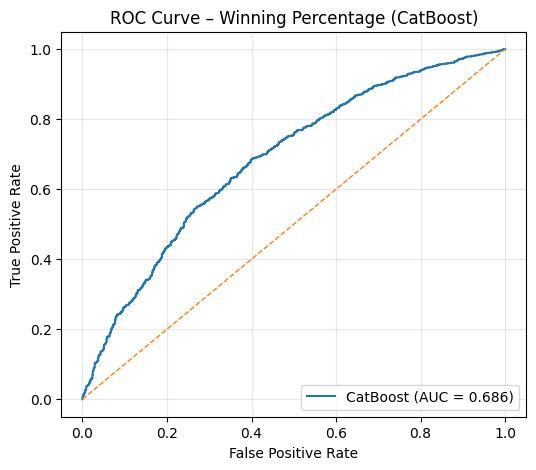

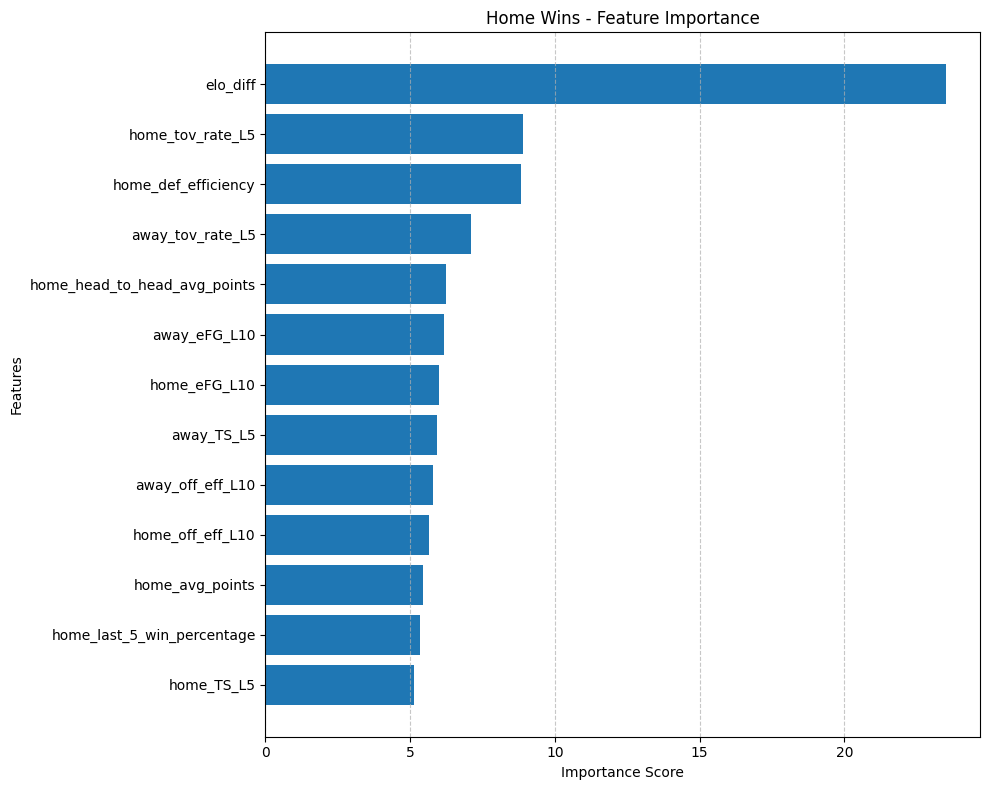

In [ ]:
# # # # # # #
# CatBoost #
# # # # # # #

features = optimal_features

df_model = df[features].copy()
feature_medians = df_model[features].median().to_dict()

df_model['home_win'] = df['home_win']

for col in features:
    df_model[col] = df_model[col].fillna(df_model[col].median())

X = df_model[features]
y = df_model['home_win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=0
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob_cb = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob_cb)

print(f'Accuracy: {acc:.4f}')
print(f'AUC: {auc:.4f}')

fpr, tpr, thresholds = roc_curve(y_test, y_prob_cb)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Winning Percentage (CatBoost)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.show()

import pandas as pd
import matplotlib.pyplot as plt

# 1. Get feature importance from your CatBoost model
importances = model.get_feature_importance()

# 2. Create a DataFrame for easy sorting
# 'features' is the list of column names you defined earlier
feature_importance_df = pd.DataFrame({
    'Feature': features, 
    'Importance': importances
})

# 3. Sort features (Ascending order looks best for horizontal bar charts)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# 4. Plot the results
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Home Wins - Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save or show the plot
plt.savefig('feature_importance.png')
plt.show()

In [26]:
# # # # # # # # # # # # # # # # # # # #
# Ensemble – Logistic + RF + CatBoost #
# # # # # # # # # # # # # # # # # # # #

ensemble_prob = (y_prob_lr + y_prob_rf + y_prob_cb) / 3
ensemble_pred = (ensemble_prob > 0.5).astype(int)

acc = accuracy_score(y_test, ensemble_pred)
auc = roc_auc_score(y_test, ensemble_prob)

print(f'Accuracy: {acc:.4f}')
print(f'AUC: {auc:.4f}')


Accuracy: 0.5000
AUC: 0.5714


In [27]:
features = optimal_features

df_model = df[features].copy()
df_model['home_win'] = df['home_win']

for col in features:
    df_model[col] = df_model[col].fillna(df_model[col].median())

X = df_model[features]
y = df_model['home_win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    class_weight='balanced',
    random_state=42
)

# IMPORTANT: SVM requires scaled features
svm.fit(X_train_scaled, y_train)

svm_prob = svm.predict_proba(X_test_scaled)[:, 1]
svm_pred = (svm_prob > 0.5).astype(int)

svm_auc = roc_auc_score(y_test, svm_prob)
svm_acc = accuracy_score(y_test, svm_pred)

print(f"SVM AUC: {svm_auc:.4f}")
print(f"SVM Acc: {svm_acc:.4f}")

SVM AUC: 0.5238
SVM Acc: 0.5625


In [6]:
base_dir = os.path.dirname(os.getcwd())  # this points to 'Scripts/ai'
models_dir = os.path.join(base_dir, 'models')
scalers_dir = os.path.join(base_dir, 'scalers')

MODEL_PATH = os.path.join(models_dir, 'win_probability_model.pkl')
SCALER_PATH = os.path.join(scalers_dir, 'win_probability_scaler.pkl')

# joblib.dump(model, MODEL_PATH)
# joblib.dump(scaler, SCALER_PATH)
joblib.dump(feature_medians, os.path.join(models_dir, "feature_medians.pkl"))

['/Users/simonsalaj/Documents/test_ai/StatistIQApp/Scripts/ai/models/feature_medians.pkl']